In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
df = pd.read_csv('../data/train.csv')
df.shape

(115475, 13)

In [2]:
# Filter duplicate rows
df = df.drop_duplicates()
df.shape

(114765, 13)

In [3]:
# Explore label imbalance
df[df['feedback'] == 1].size / df.size

0.8772012373110268

In [4]:
# Explore feature dofs
[print(colname, df[colname].unique().size) for colname in sorted(df.columns)];

action_recommendation_category 6
action_recommendation_id 295
action_recommendation_type 3
case_id 73945
completion_date 466
equipment_area 1285
equipment_category 20
equipment_id 30000
feedback 2
floors_category 8
load_category 8
speed_category 8
usage_type 13


In [5]:
# Group target feature names
categorical_feature_names = [
    'action_recommendation_id',
    'action_recommendation_category',
    'equipment_area',
    'equipment_category',
    'usage_type'
]
ordinal_feature_names = [
    'floors_category',
    'load_category',
    'speed_category',
]

In [6]:
# Employ label encoder to convert categories to numeric
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder = defaultdict(LabelEncoder)
label_encoder

defaultdict(sklearn.preprocessing._label.LabelEncoder, {})

In [7]:
# Group features and labels
x = pd.concat([df[categorical_feature_names].apply(lambda f: label_encoder[f.name].fit_transform(f)),
    df[ordinal_feature_names]], axis=1)
y = df.feedback
x.shape, y.shape

((114765, 8), (114765,))

In [8]:
#x.hist(figsize=(15, 10))

<BarContainer object of 295 artists>

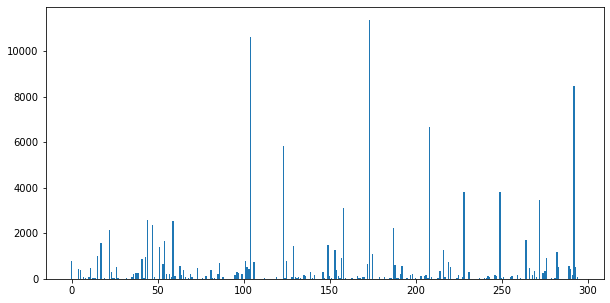

In [9]:
# Plot incidence counts for each action recommendation id
ar_groups = x.groupby('action_recommendation_id').size()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(ar_groups.index, ar_groups.values)

In [10]:
# Apply train, test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((91812, 8), (22953, 8), (91812,), (22953,))

In [11]:
# Explore imbalance
y_train[y_train == 1].size / y_train.size, y_test[y_test == 1].size / y_test.size

(0.876955082124341, 0.8781858580577703)

# Model

In [12]:
from custom.metrics import *

In [13]:
%%time
# Compute baseline with lightgbm
import lightgbm
lgb = lightgbm.LGBMClassifier(random_state=0)
lgb.fit(x_train, y_train)
lgb.score(x_test, y_test)

CPU times: user 1.36 s, sys: 16.7 ms, total: 1.37 s
Wall time: 214 ms


0.8887727094497452

In [14]:
f2_score(y_test, lgb.predict(x_test))

0.9693996502817175

In [15]:
f2_score(y_test, np.ones_like(y_test))

0.9730066324905146

In [ ]:
print(confusion_matrix(y_test, lgb.predict(x_test)))
print(classification_report(y_test, lgb.predict(x_test)))

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=500,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=0
)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

In [ ]:
f2_score(y_test, rf.predict(x_test))

In [ ]:
print(confusion_matrix(y_test, rf.predict(x_test)))
print(classification_report(y_test, rf.predict(x_test)))